# Preprocessing 
Using the preprocess script and saving the processed file in new location

In [73]:
path2csv = "data/marketing_campaign.csv"
path2processedcsv = "data/processed_marketing_campaign.csv"

In [74]:
!python preprocess.py \
    --pathToCSV data/marketing_campaign.csv \
    --pathToSaveProcessedCSV data/processed_marketing_campaign.csv

---Started Preprocessing---


Dropping rows having null values
Extracting new feature from Birth Year feature
     ID  Year_Birth   Education  ... Z_Revenue  Response  Age
0  5524        1957  Graduation  ...        11         1   64
1  2174        1954  Graduation  ...        11         0   67
2  4141        1965  Graduation  ...        11         0   56
3  6182        1984  Graduation  ...        11         0   37
4  5324        1981         PhD  ...        11         0   40

[5 rows x 30 columns]


 Creating new feature total spent from spent features 
     ID  Year_Birth   Education  ... Response  Age  TotalSpent
0  5524        1957  Graduation  ...        1   64        1617
1  2174        1954  Graduation  ...        0   67          27
2  4141        1965  Graduation  ...        0   56         776
3  6182        1984  Graduation  ...        0   37          53
4  5324        1981         PhD  ...        0   40         422

[5 rows x 31 columns]

 
Extracing Months spent on the plat

# Exploratory Data Analysis

In [98]:
import pandas as pd

In [99]:
df = pd.read_csv(path2processedcsv)

In [100]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,TotalSpent,Mn_Customer,AgeGroup,Children,campaignConvert
0,-0.790438,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,1.936840,1.237486,-1.264598,1
1,-0.790438,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.714136,1.237486,1.404572,0
2,-0.790438,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,-0.149432,-0.221639,-1.264598,0
3,-0.790438,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,-1.974920,-1.680765,0.069987,0
4,1.590024,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,-0.801392,-0.221639,0.069987,0


In [63]:
df.iloc[:, 1]

0       0.287105
1      -0.260882
2       0.913196
3      -1.176114
4       0.294307
          ...   
2207    0.430444
2208    0.560123
2209    0.233347
2210    0.803172
2211    0.042290
Name: Income, Length: 2212, dtype: float64

In [64]:
df.Income.describe()

count    2.212000e+03
mean    -1.252765e-16
std      1.000226e+00
min     -2.333791e+00
25%     -7.771113e-01
50%     -2.731156e-02
75%      7.679525e-01
max      5.131311e+00
Name: Income, dtype: float64

In [65]:
df.campaignConvert

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2207    1.0
2208    0.0
2209    0.0
2210    0.0
2211    0.0
Name: campaignConvert, Length: 2212, dtype: float64

In [66]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'TotalSpent', 'Mn_Customer', 'AgeGroup', 'Children', 'campaignConvert'],
      dtype='object')

## KMeans

For choosing the number of clusters. I will be doing silhouette analysis. 

In [76]:
import matplotlib.pyplot as plt

In [77]:
%matplotlib inline

In [84]:
!python kmeans.py --cluster_sizes 2 3 4 5 6

For n_clusters = 2 The average silhouette_score is : 0.27326552267048987
For n_clusters = 3 The average silhouette_score is : 0.19688488719210678
For n_clusters = 4 The average silhouette_score is : 0.14854836546963515
For n_clusters = 5 The average silhouette_score is : 0.1458417166576397
For n_clusters = 6 The average silhouette_score is : 0.1359193502106451


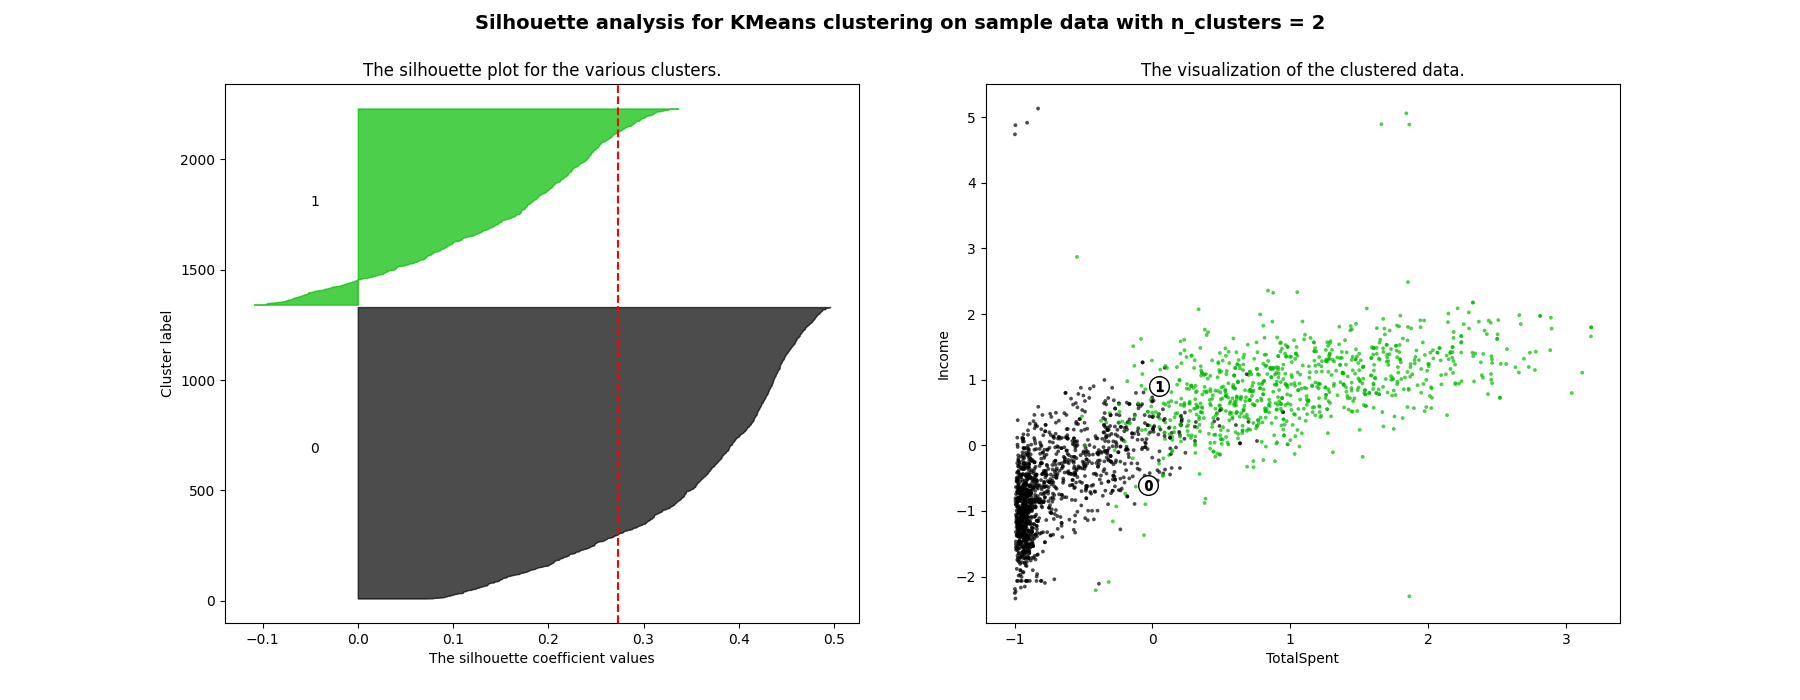

In [88]:
from IPython.display import Image
Image(filename=f'silhouette_analysis{2}.png')

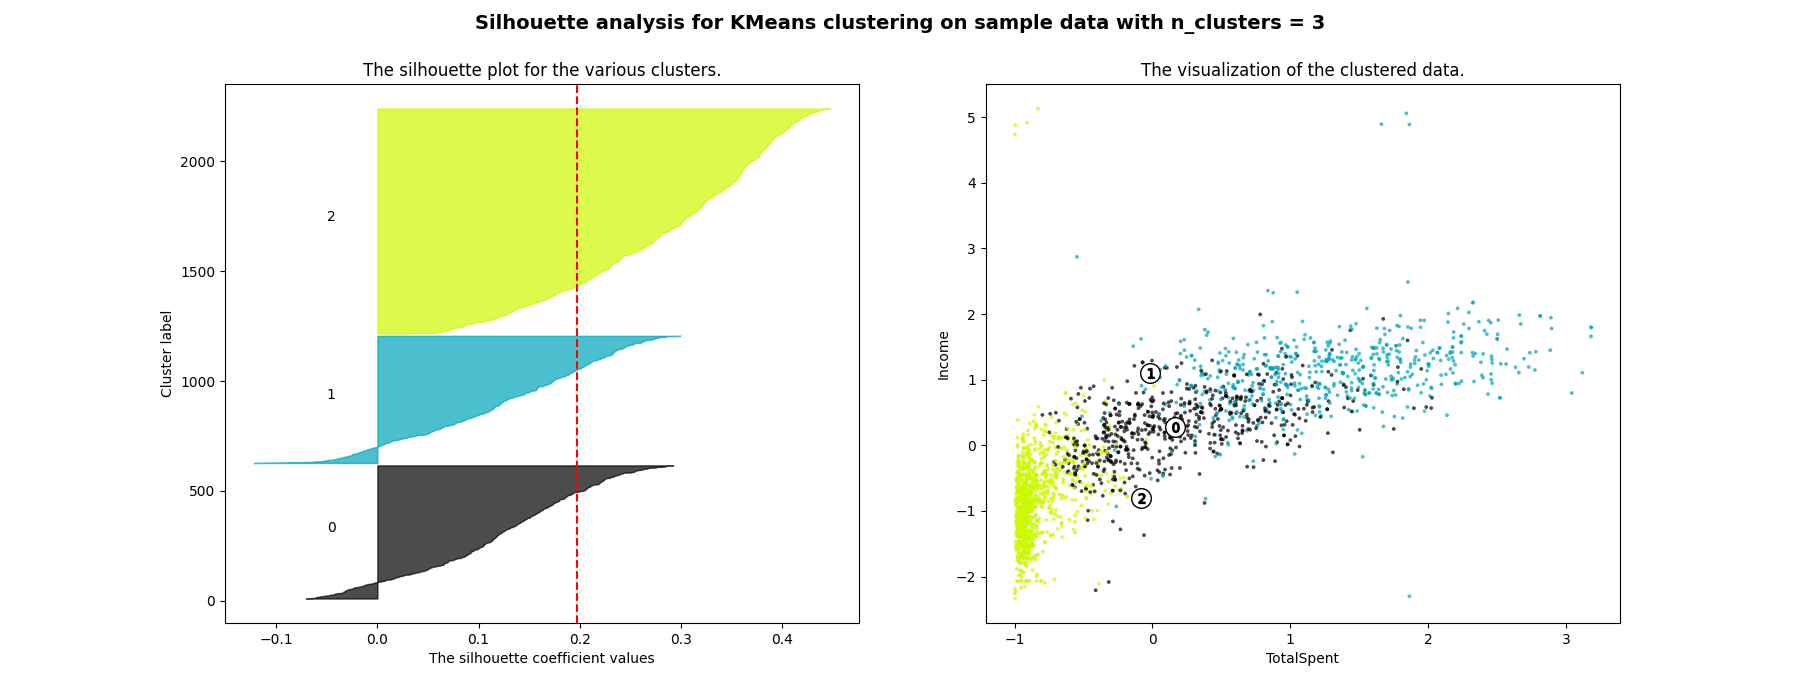

In [89]:
Image(filename=f'silhouette_analysis{3}.png')

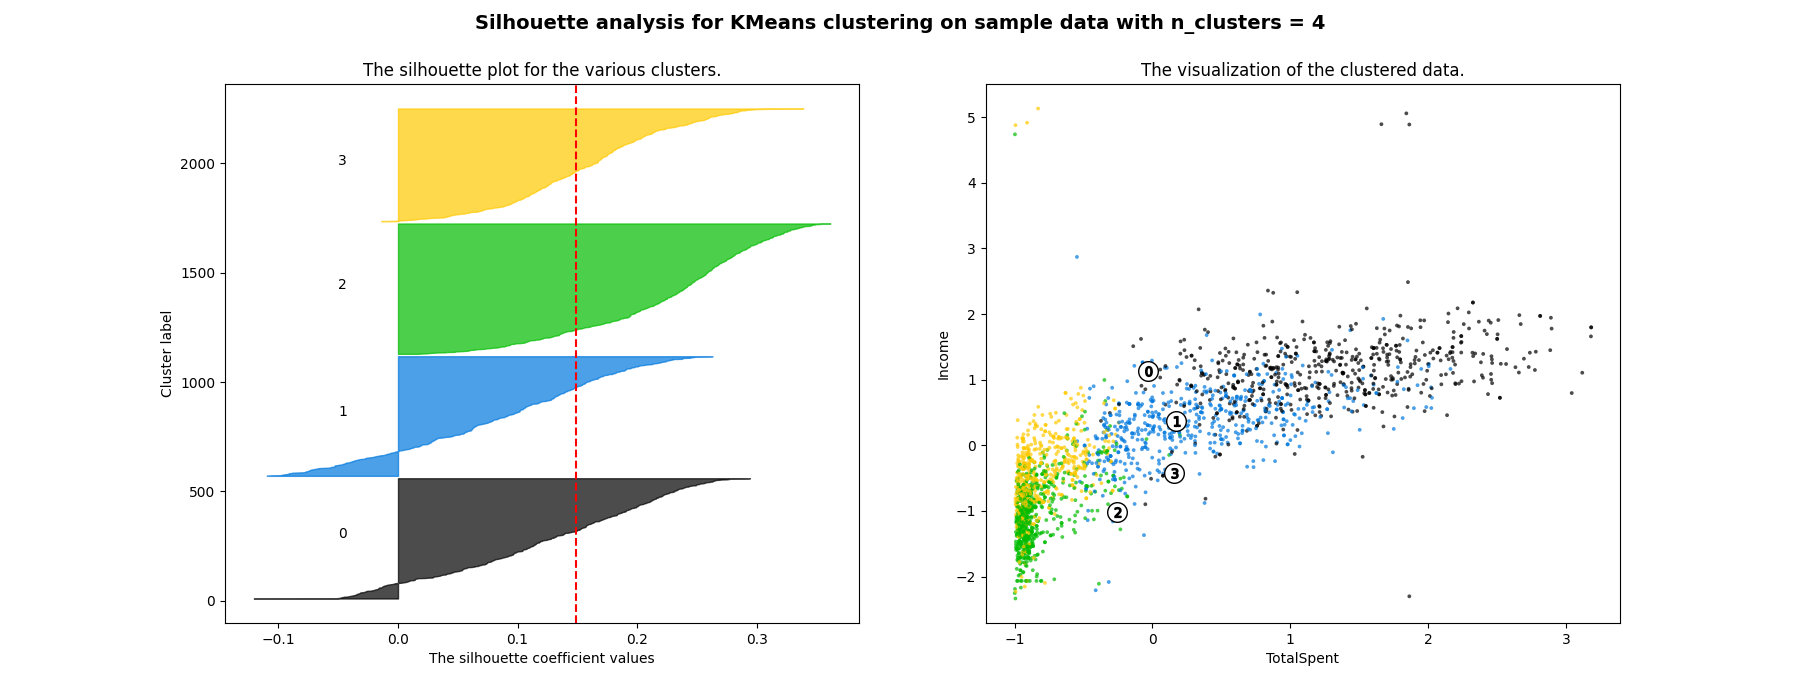

In [90]:
Image(filename=f'silhouette_analysis{4}.png')

Using SSE and silhouette analysis, we choose 4 as number of clusters. 

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans()

In [101]:
# Clustering
kmeans = KMeans(n_clusters= 4)
clusters = kmeans.fit_predict(df)

In [102]:
df_clusters = pd.concat([df, pd.DataFrame({'cluster': clusters})], axis=1)

C:\Users\Prashant\Desktop\Customer Personality Analysis\venv\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


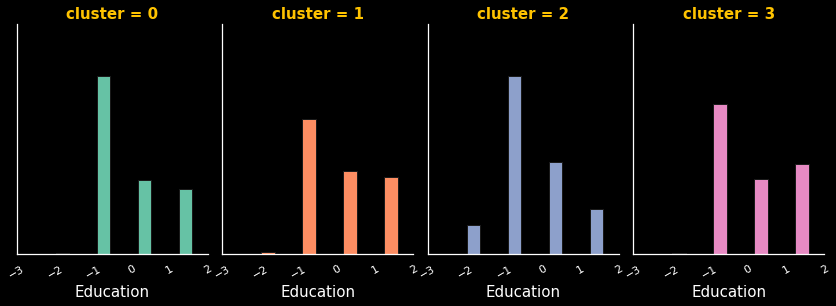

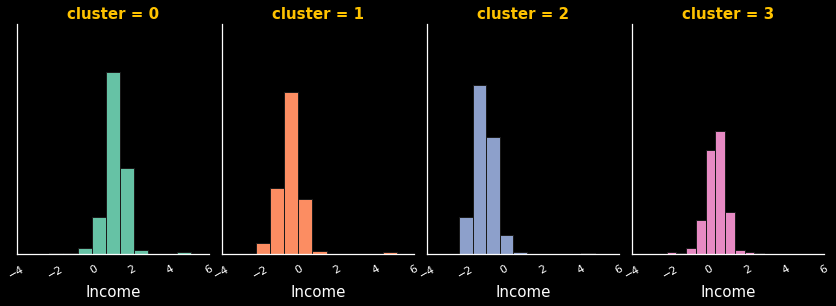

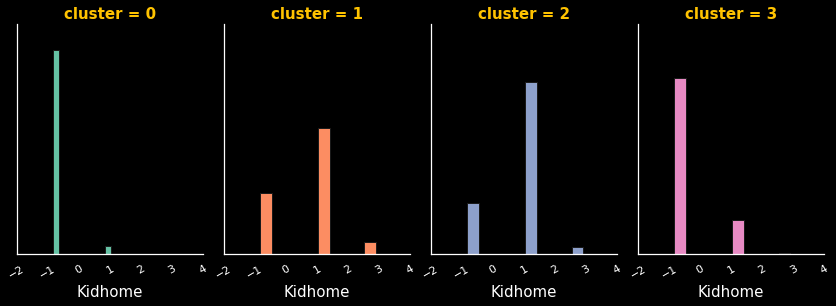

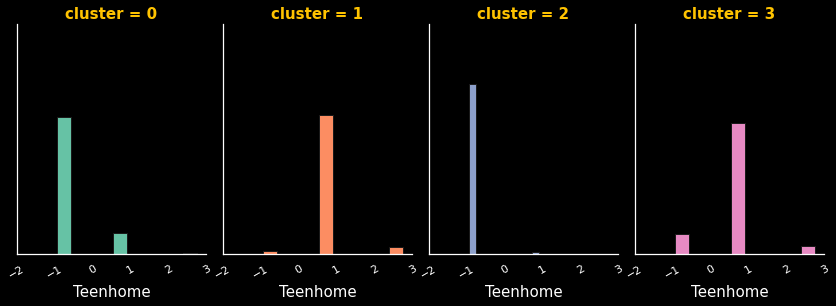

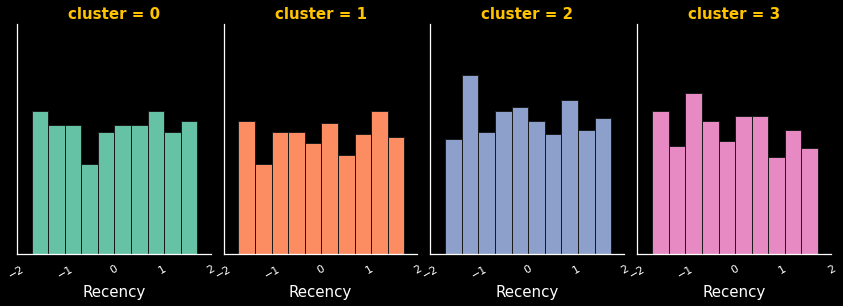

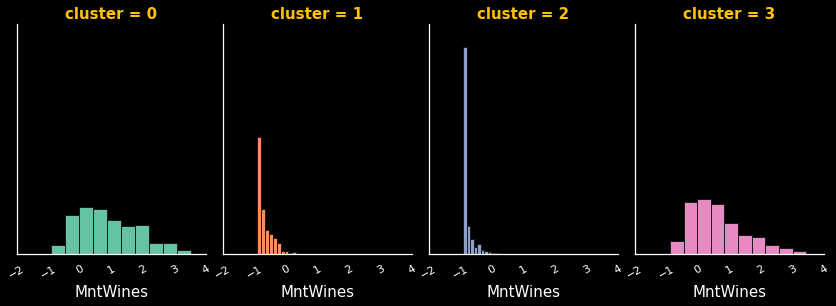

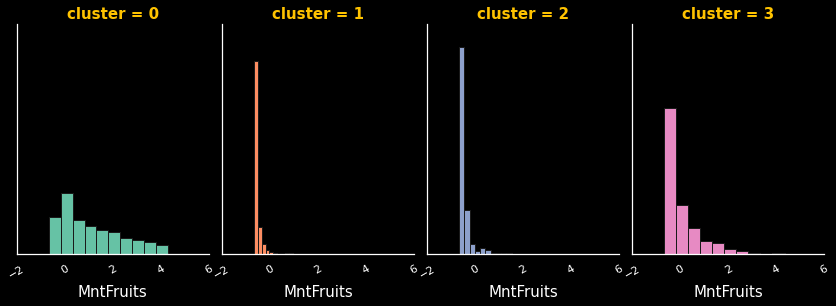

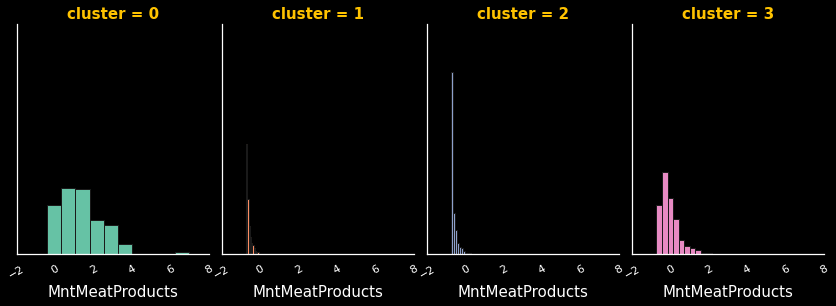

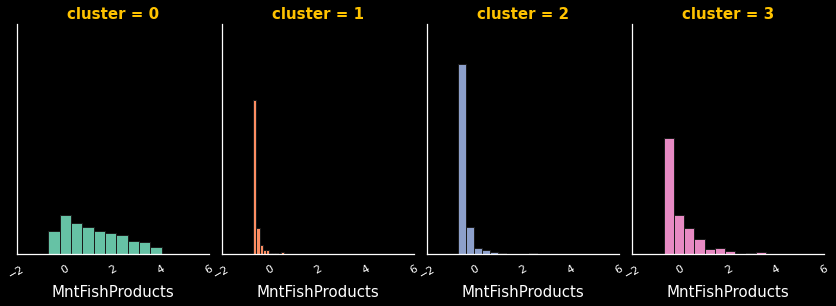

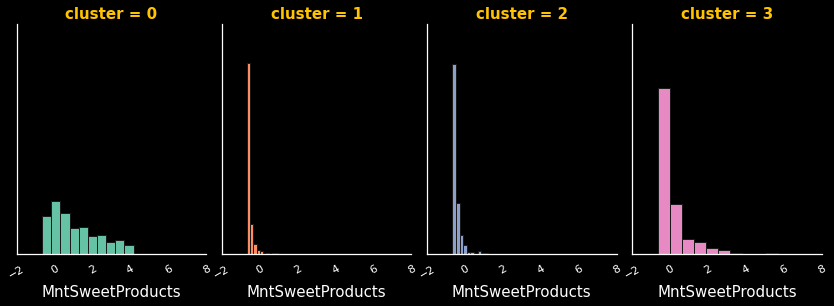

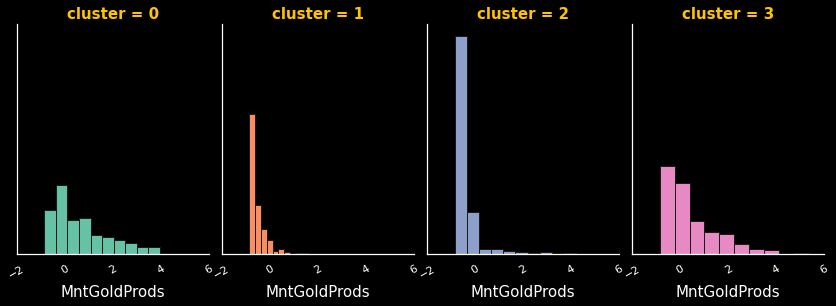

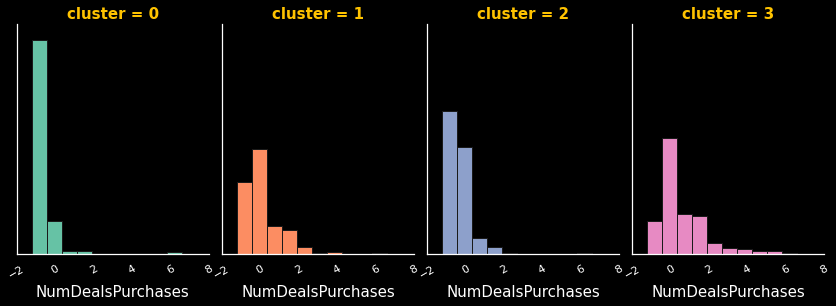

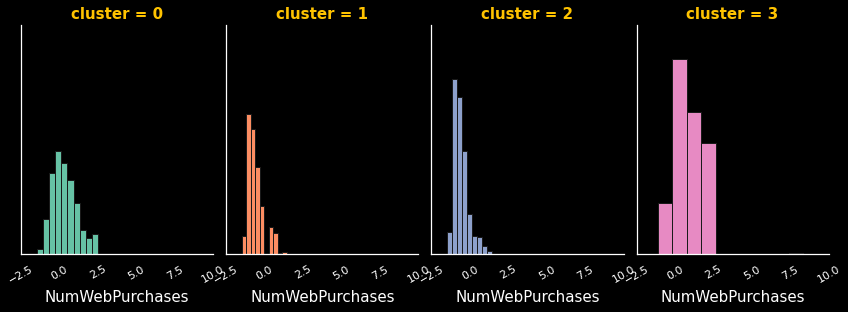

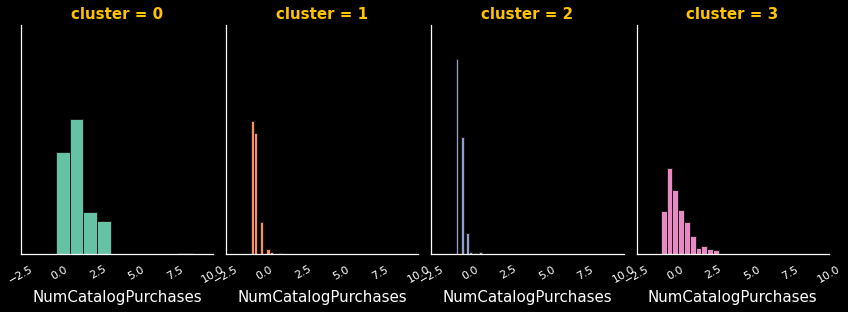

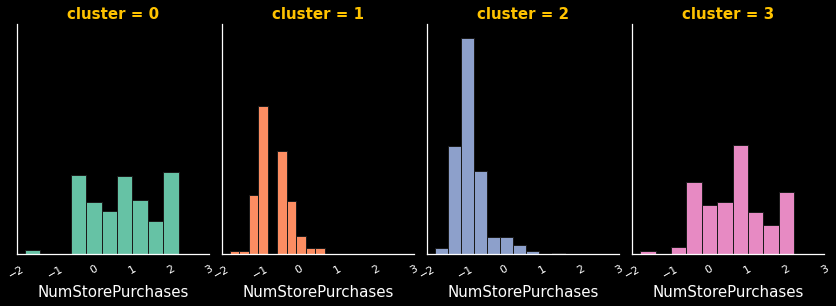

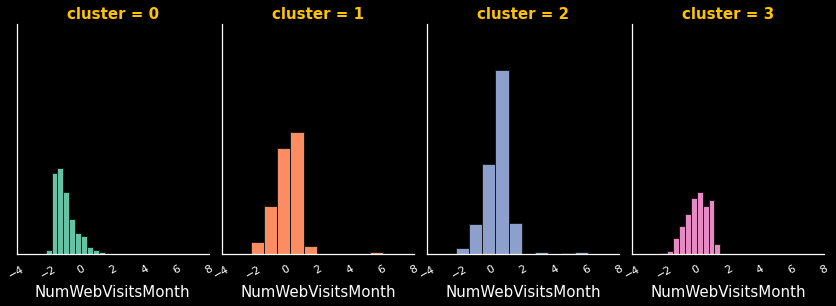

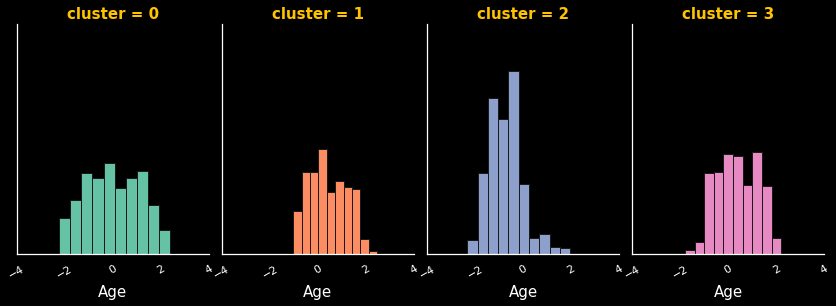

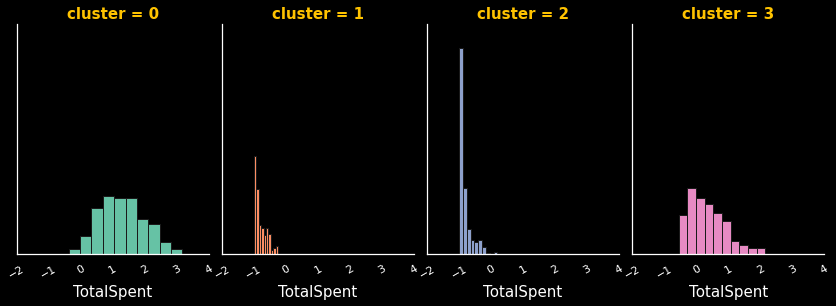

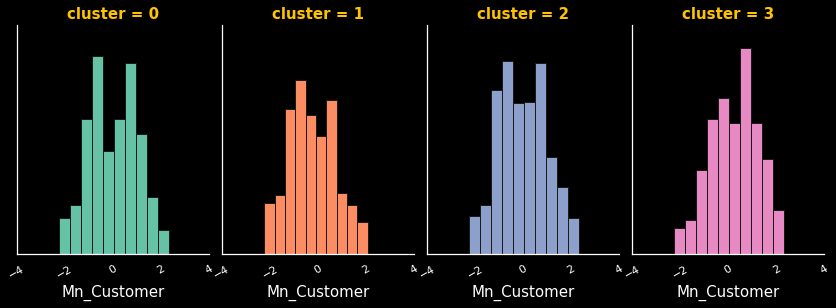

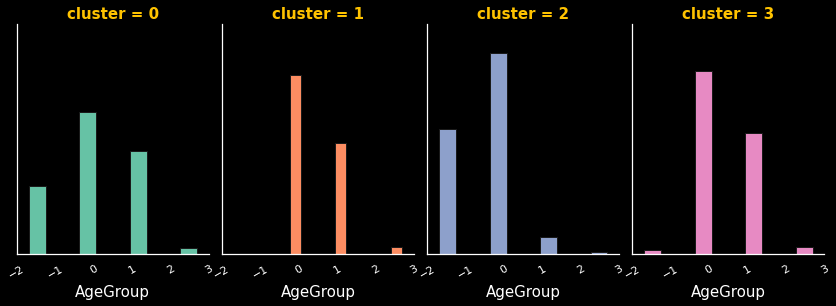

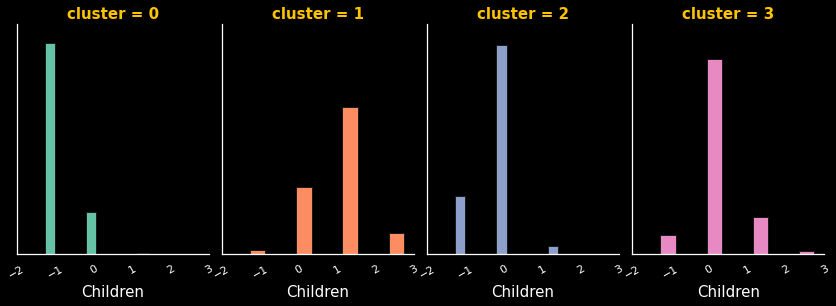

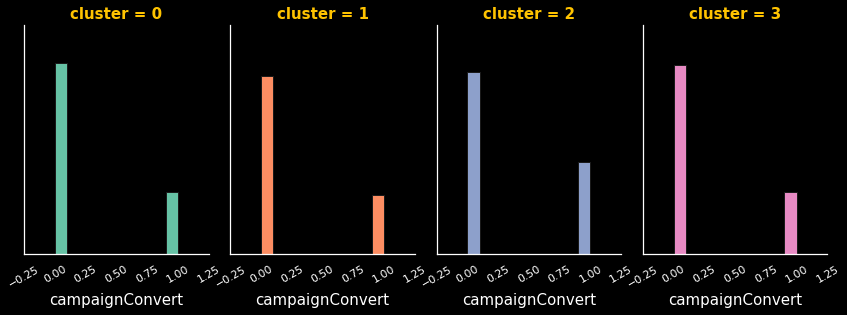

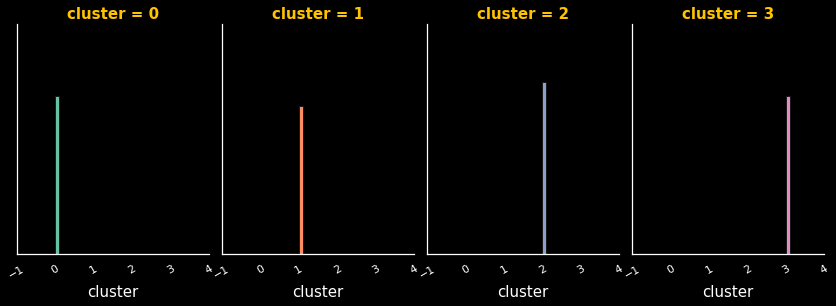

In [106]:
# Clusters interpretation
import seaborn as sns
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'DejaVu Sans'})

for i in df_clusters:
    g = sns.FacetGrid(df_clusters, col = "cluster", hue = "cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)